In [2]:
#load data
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff
import json

data1, meta1 = loadarff('./data/steel-plates-fault.arff')
data2, meta2 = loadarff('./data/ionosphere.arff')
data3, meta3 = loadarff('./data/banknotes.arff')

df1 = pd.DataFrame(data1)
df2 = pd.DataFrame(data2)
df3 = pd.DataFrame(data3)
df1.name = "steel-plates-fault"
df2.name = "ionosphere"
df3.name = "banknotes"


accuracy_map = {
    "KNN":{},
    "GaussianNB":{},
    "LR":{},
    "DT":{},
    "Gradient Boosted DTs":{},
    "Random Forest":{},
    "MLP":{},
}

try:
    with open('accuracy_data.json', 'r') as f:
        loaded_data = json.load(f)
    accuracy_map.update(loaded_data)

except FileNotFoundError:
    pass

In [31]:
#prepare data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

def prep_data(df):
    x = df.drop(df.columns[-1],axis=1)
    y = df[df.columns[-1]]
    x = x.to_numpy()
    y = le.fit_transform(y)
    return train_test_split(x, y, test_size=0.5)
    

In [13]:
#print graph
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

scientific_values_list = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
tree_depth_list = [1,3,5,8,10]
c_list = [0.1,0.5,1.0,2.0,5.0]
mlp_alpha_list = [1e-5, 1e-3, 0.1, 10]

def print_graph(acc, title, xlabel):
    fig, ax = plt.subplots()
    x_values = list(acc.keys())
    accuracy_scores = list(acc.values())
    if title.find("(KNN)") != -1:
        ax.boxplot(accuracy_scores)
        plt.xticks(np.arange(1, 6, 1))
    if title.find("(GaussianNB)") != -1:
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        ax.boxplot(accuracy_scores, positions=np.arange(1, len(scientific_values_list) + 1))
        plt.xticks(np.arange(1, len(scientific_values_list) + 1), scientific_values_list)
    if title.find("(DT)") != -1 or title.find("(Gradient Boosted DTs)") != -1 or title.find("(Random Forest)") != -1:
        ax.boxplot(accuracy_scores, positions=np.arange(1, len(tree_depth_list) + 1))
        plt.xticks(np.arange(1, len(tree_depth_list) + 1), tree_depth_list)
    if title.find("(LR)") != -1:
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        ax.boxplot(accuracy_scores, positions=np.arange(1, len(c_list) + 1))
        plt.xticks(np.arange(1, len(c_list) + 1), c_list)
    if title.find("(MLP)") != -1:
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
        ax.boxplot(accuracy_scores, positions=np.arange(1, len(mlp_alpha_list) + 1))
        plt.xticks(np.arange(1, len(mlp_alpha_list) + 1), mlp_alpha_list)
    plt.title(f"{title}") 
    plt.ylabel('Accuracy') 
    plt.xlabel(f"{xlabel}") 
    plt.savefig(f"./plots/classifiers/{title}.png")
    

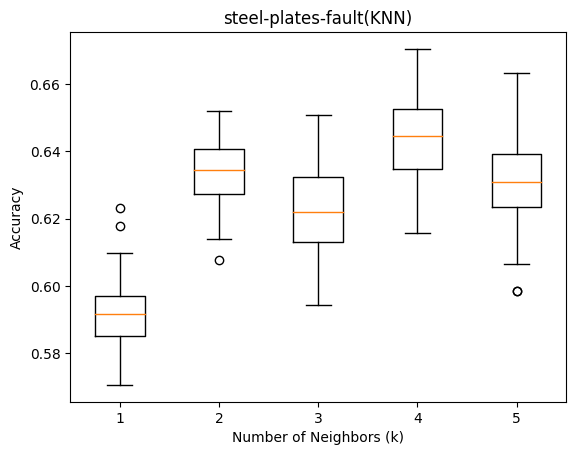

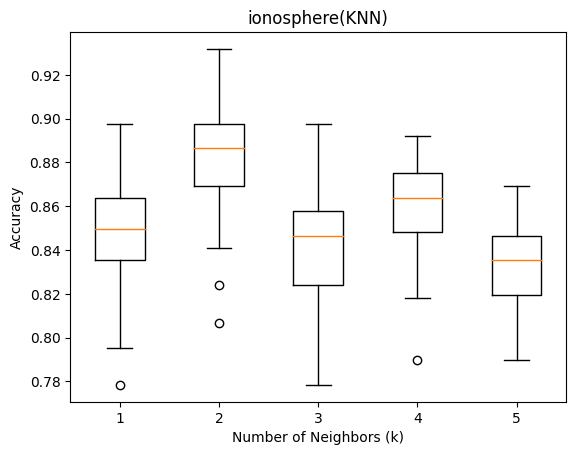

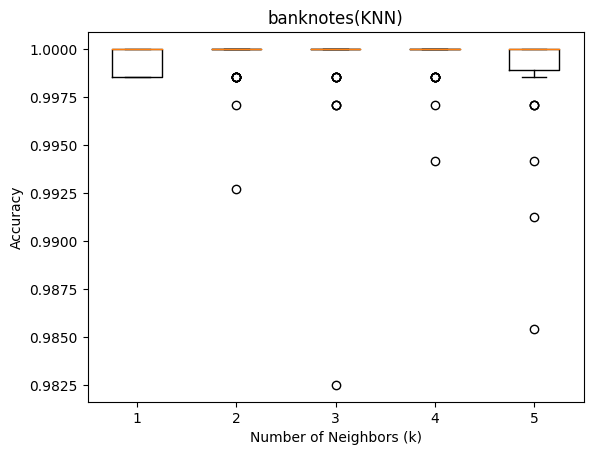

In [33]:
#KNeighborsClassifier (K nearest neighbours) 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

def knn_classifier(df):
    map = {}
    for k in range(1,6):
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            neigh = KNeighborsClassifier(n_neighbors = k)
            neigh.fit(train_x,train_y)
            predictions = neigh.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[k] = accuracy
        title = f"{df.name}(KNN)"
    accuracy_map["KNN"][df.name] = map
    print_graph(map,title,"Number of Neighbors (k)")


knn_classifier(df1)
knn_classifier(df2)
knn_classifier(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)

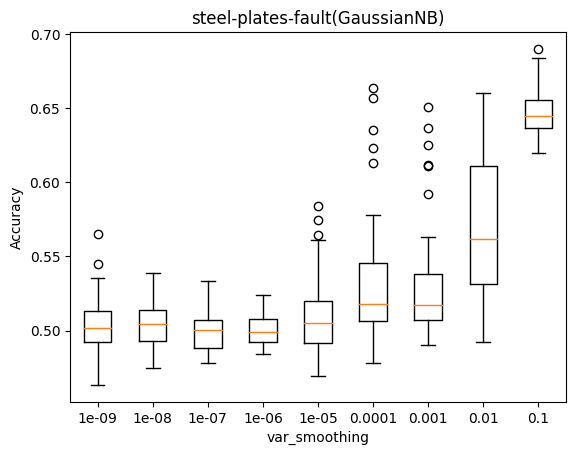

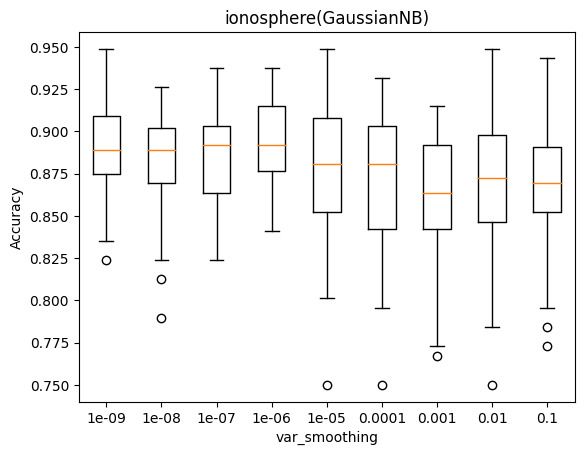

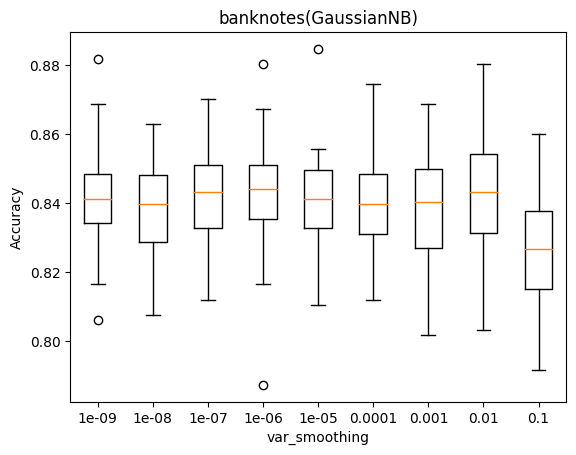

In [34]:
# GaussianNB (the Gaussian form of Naive Bayes)
from sklearn.naive_bayes import GaussianNB

def gaussiannb_classifier(df):
    map={}
    for v in scientific_values_list:
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            clf = GaussianNB(var_smoothing=v)
            clf.fit(train_x,train_y)
            predictions = clf.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[v] = accuracy
    title = f"{df.name}(GaussianNB)"
    accuracy_map["GaussianNB"][df.name] = map
    print_graph(map,title,"var_smoothing")


gaussiannb_classifier(df1)
gaussiannb_classifier(df2)
gaussiannb_classifier(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)


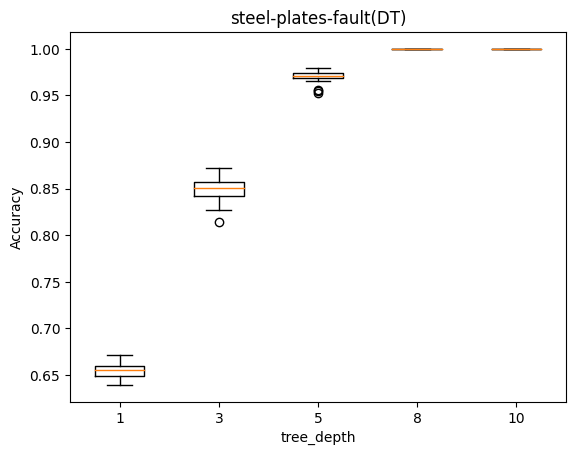

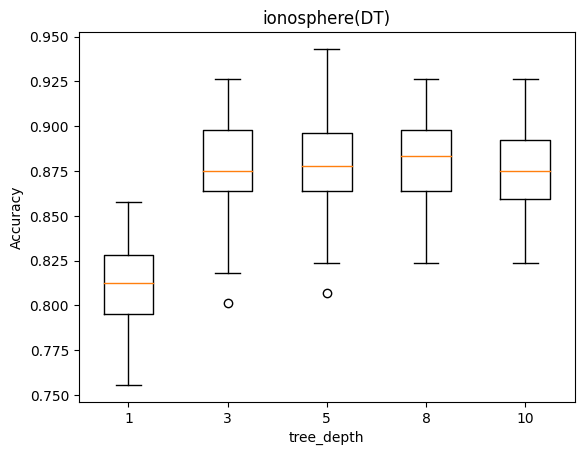

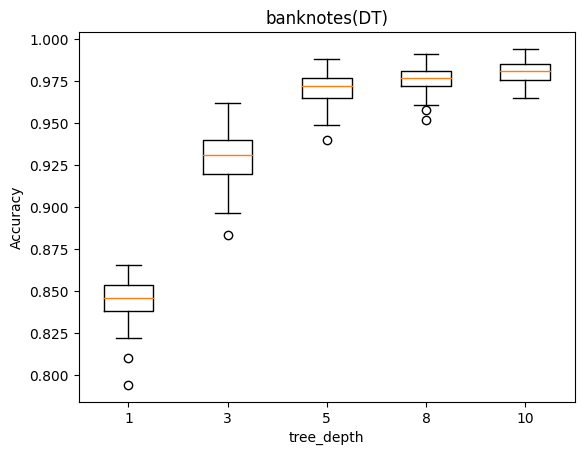

In [35]:
#DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

def decision_tree_classifier(df):
    map={}
    for d in tree_depth_list:
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            dt_clf = DecisionTreeClassifier(max_depth=d, random_state=0)
            dt_clf.fit(train_x, train_y)
            predictions = dt_clf.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[d] = accuracy
    title = f"{df.name}(DT)"
    accuracy_map["DT"][df.name] = map
    print_graph(map,title,"tree_depth")


decision_tree_classifier(df1)
decision_tree_classifier(df2)
decision_tree_classifier(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)


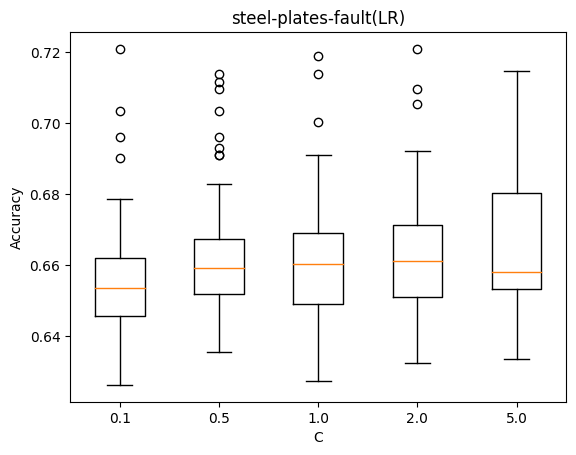

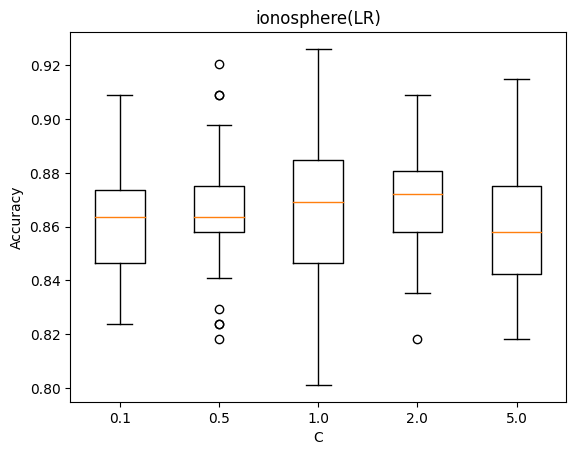

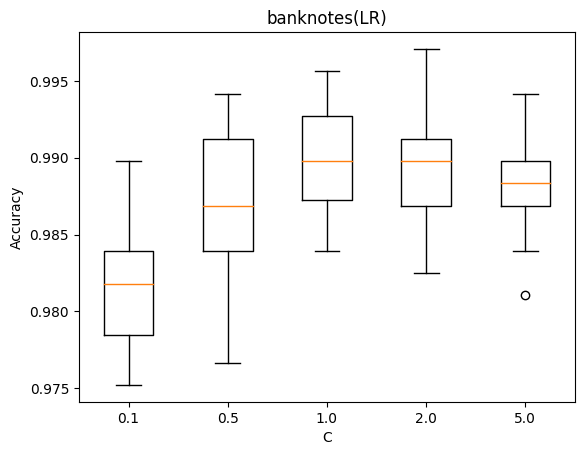

In [36]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression

def logistic_regression(df):
    map = {}
    for c in c_list:
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            logreg = LogisticRegression(C=c, max_iter=1200)
            logreg.fit(train_x, train_y)
            predictions = logreg.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[c] = accuracy
    title = f"{df.name}(LR)"
    accuracy_map["LR"][df.name] = map
    print_graph(map,title,"C")


logistic_regression(df1)
logistic_regression(df2)
logistic_regression(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)

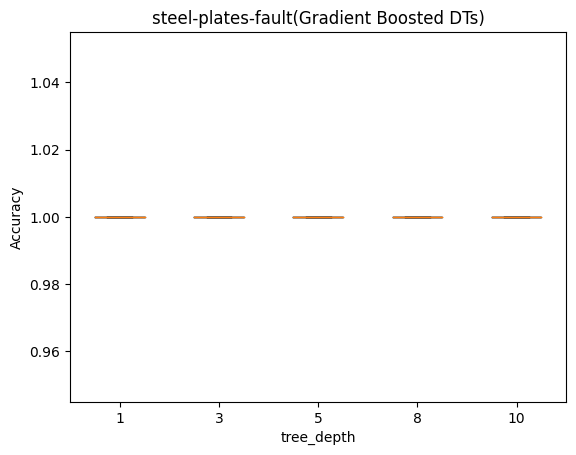

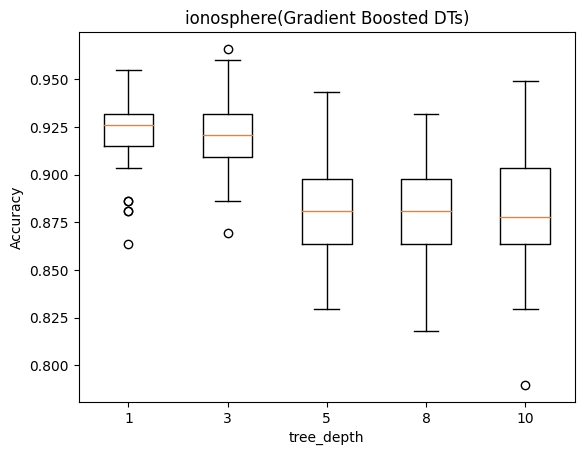

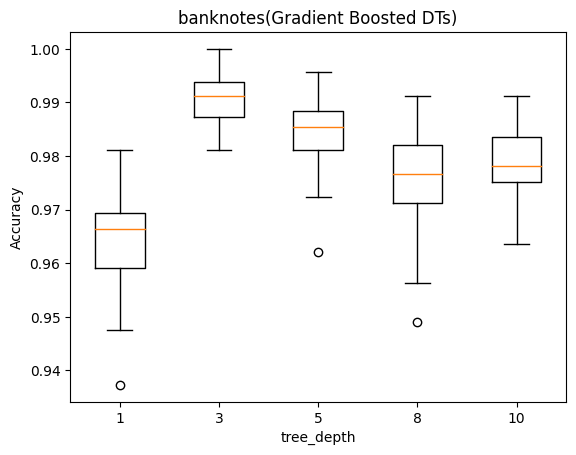

In [37]:
#GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
def gradient_boosting_classifier(df):
    map={}
    for d in tree_depth_list:
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=d, random_state=543)
            gb_clf.fit(train_x, train_y)
            gb_clf.predict(test_x)
            predictions = gb_clf.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[d] = accuracy
    title = f"{df.name}(Gradient Boosted DTs)"
    accuracy_map["Gradient Boosted DTs"][df.name] = map
    print_graph(map,title,"tree_depth")


gradient_boosting_classifier(df1)
gradient_boosting_classifier(df2)
gradient_boosting_classifier(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)

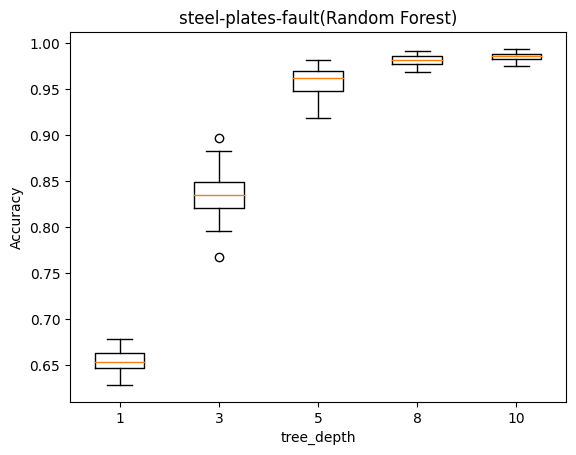

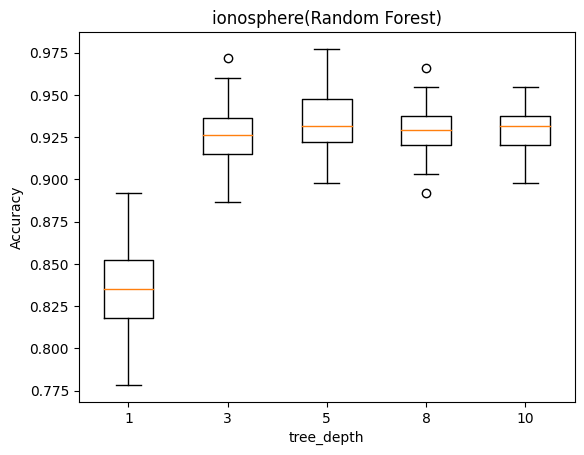

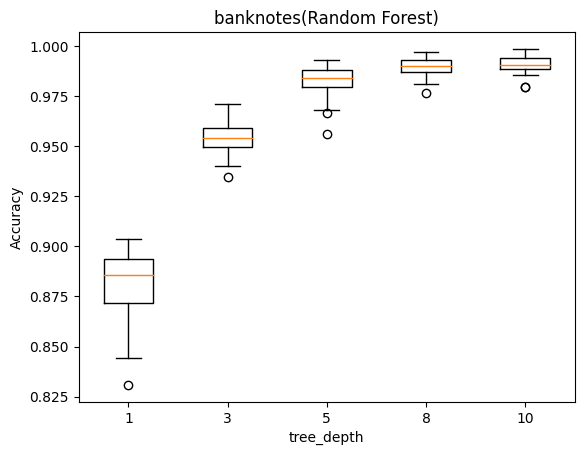

In [38]:
#RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(df):
    map = {}
    for d in tree_depth_list:
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            rf_clf = RandomForestClassifier(n_estimators=500, max_depth=d, random_state=33)
            rf_clf.fit(train_x, train_y)
            predictions = rf_clf.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[d] = accuracy
    title = f"{df.name}(Random Forest)"
    accuracy_map["Random Forest"][df.name] = map
    print_graph(map,title,"tree_depth")


random_forest_classifier(df1)
random_forest_classifier(df2)
random_forest_classifier(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)

/home/gawk/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/gawk/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/gawk/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

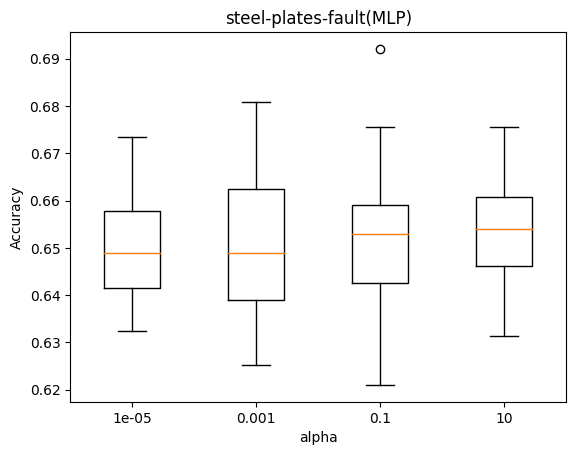

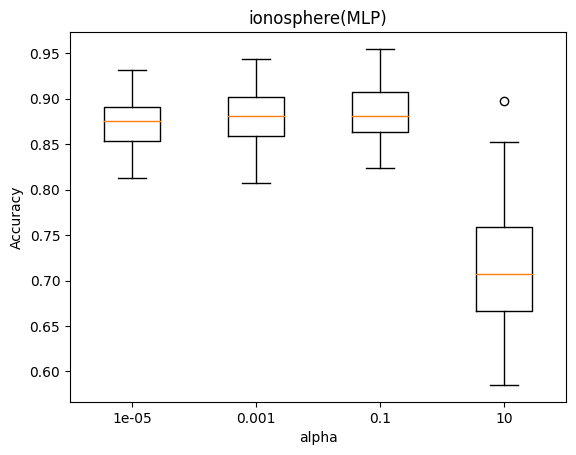

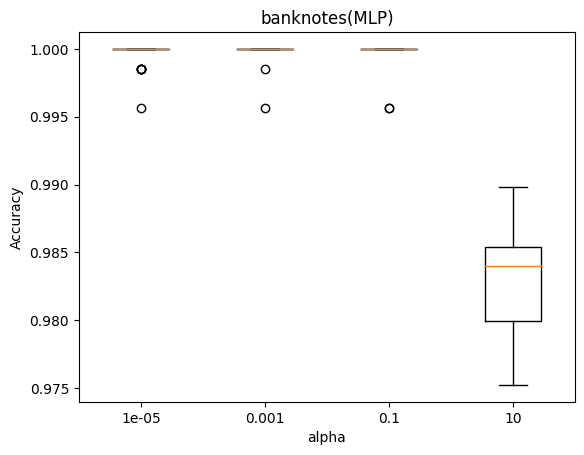

In [39]:
#MLPClassifier
from sklearn.neural_network import MLPClassifier

def neural_network(df):
    map = {}
    for a in mlp_alpha_list:
        accuracy = np.ones((50,),dtype=float)
        for i in range(0,50):
            train_x,test_x,train_y,test_y = prep_data(df)
            mlp_clf = MLPClassifier(random_state=0, max_iter=500,alpha=a, activation="logistic",solver='lbfgs')
            mlp_clf.fit(train_x, train_y)
            predictions = mlp_clf.predict(test_x)
            accuracy[i] = accuracy_score(test_y, predictions)
        map[a] = accuracy
    title = f"{df.name}(MLP)"
    accuracy_map["MLP"][df.name] = map
    print_graph(map,title,"alpha")


neural_network(df1)
neural_network(df2)
neural_network(df3)

with open('accuracy_data.json', 'w') as f:
    # Convert ndarray elements to lists in the accuracy_map dictionary
    accuracy_map_json_serializable = {
        classifier: {
            dataset: {k: v.tolist() for k, v in values.items()}
            for dataset, values in classifier_values.items()
        }
        for classifier, classifier_values in accuracy_map.items()
    }

    json.dump(accuracy_map_json_serializable, f)

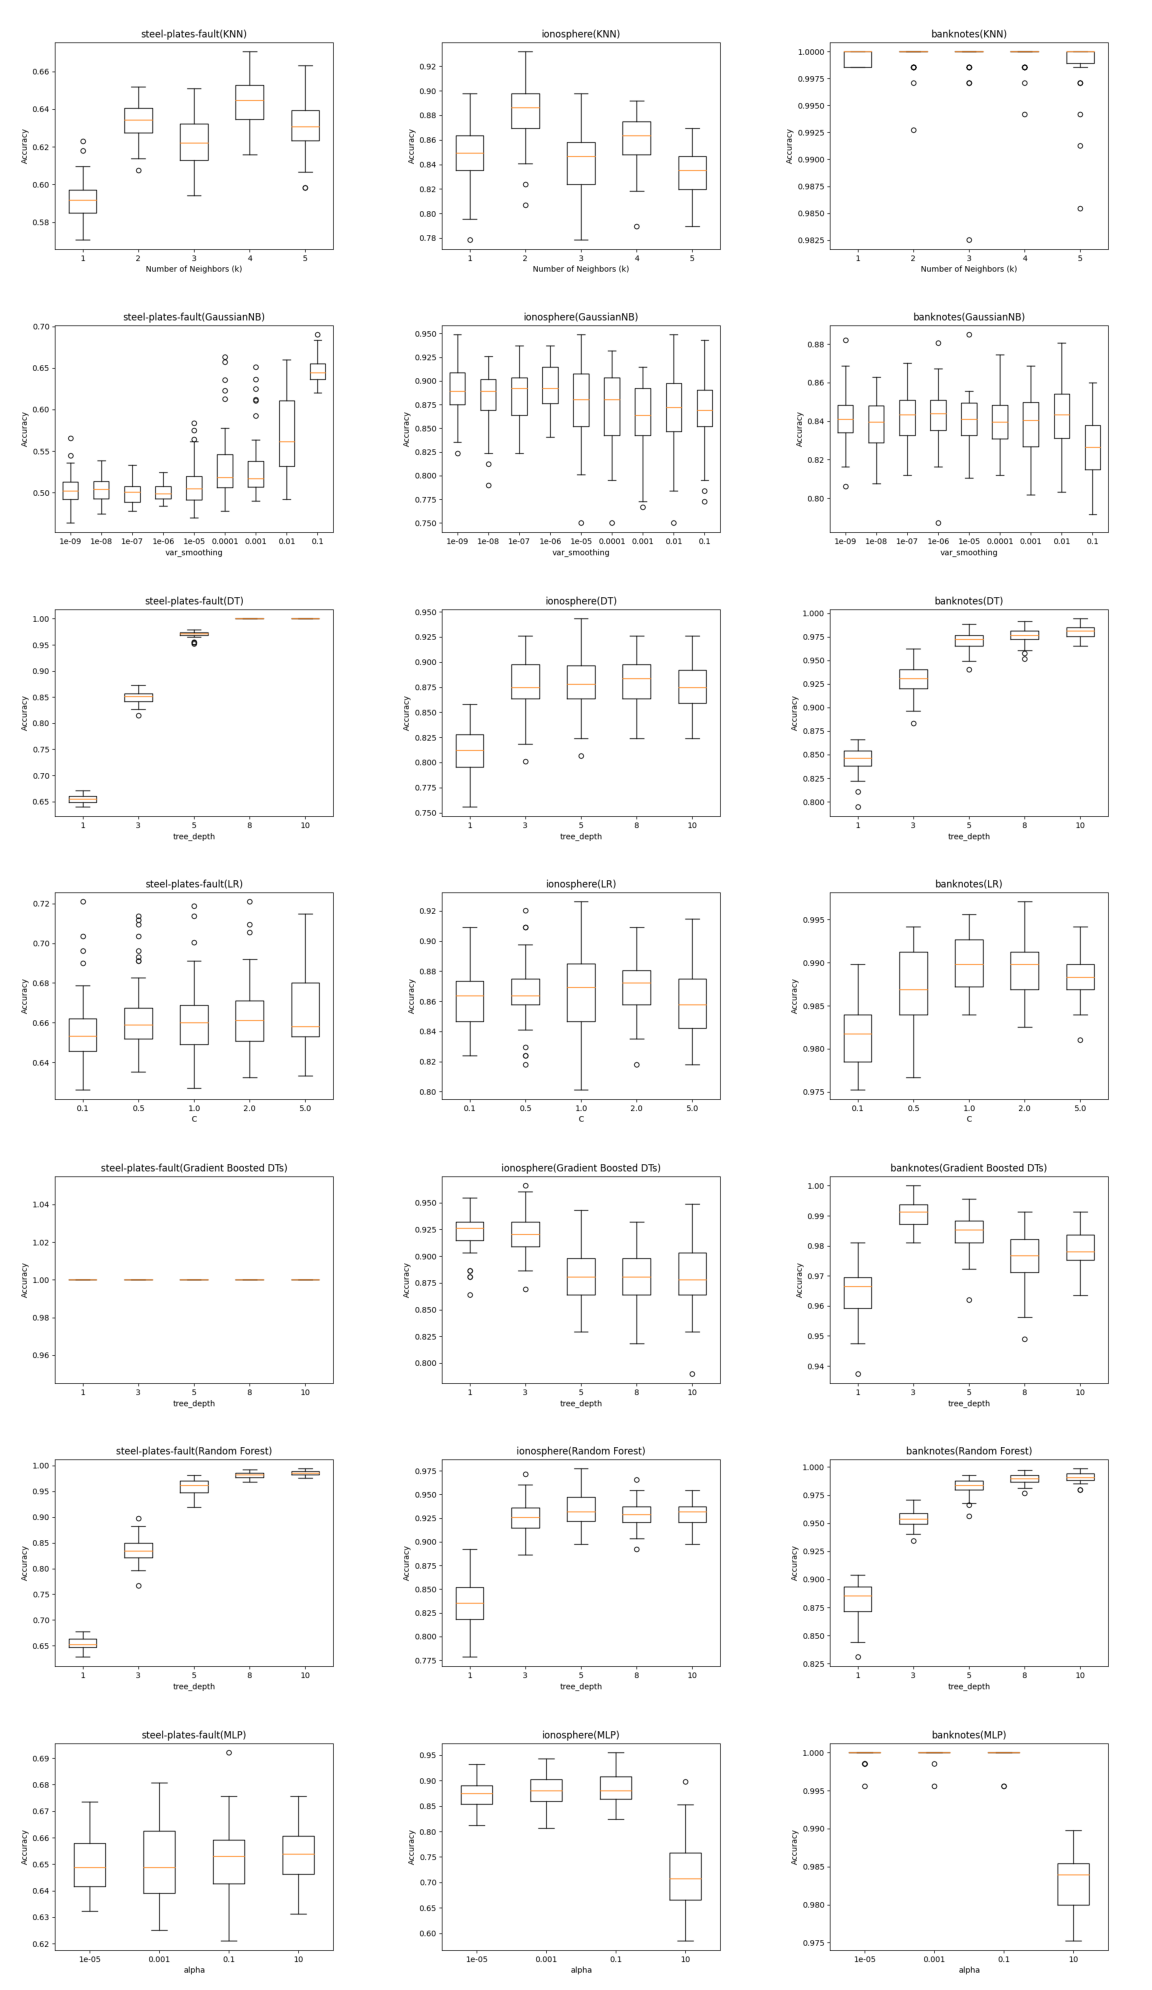

In [40]:
#print form
import matplotlib.image as mpimg

dataframes = [df1,df2,df3]
clf = ["KNN",
        "GaussianNB",
        "DT",
        "LR",
        "Gradient Boosted DTs",
        "Random Forest",
        "MLP"
        ]

fig, axs = plt.subplots(7, 3, figsize=(12, 20))

for i, c in enumerate(clf):
    for j, d in enumerate(dataframes):
        img = mpimg.imread(f"./plots/classifiers/{d.name}({c}).png")  # Load the image
        axs[i, j].imshow(img)  # Display the image
        axs[i, j].axis("off")  # Hide the axes

plt.tight_layout()
plt.savefig("./classifiers.png")





In [34]:
# get best mean value
clf_mapper={
                "KNN":{
                    "k":"n_neighbours",
                    "value_list":[1,2,3,4,5],
                },
                "GaussianNB":{
                    "k":"var smoothing",
                    "value_list":scientific_values_list,
                },
                "LR":{
                    "k":"C",
                    "value_list":c_list,
                },
                "DT":{
                    "k":"max_depth",
                    "value_list":tree_depth_list,
                },
                "Gradient Boosted DTs":{
                    "k":"max_depth",
                    "value_list":tree_depth_list,
                },
                "Random Forest":{
                    "k":"max_depth",
                    "value_list":tree_depth_list,
                },
                "MLP":{
                    "k":"alpha",
                    "value_list":mlp_alpha_list,
                },
            }
def get_best_mean_errors(accuracy_map):
    best_mean_errors = {}
    best_k_values = {}
    for classifier, datasets in accuracy_map.items():
        clf_info = clf_mapper[classifier].values()
        hyper_param = list(clf_info)[0]
        best_mean_errors[classifier] = {}
        best_k_values[f"{classifier}({hyper_param})"] = {}
        for dataset, k_values in datasets.items():
            
            mean_errors = [1 - np.mean(k_values[k]) for k in k_values]

            min_mean_error = min(mean_errors)
            best_k_index = mean_errors.index(min_mean_error) + 1
            
            best_k_value = list(clf_info)[1][best_k_index-1]
            best_mean_errors[classifier][dataset] = min_mean_error
            best_k_values[f"{classifier}({hyper_param})"][dataset] = best_k_value
    return best_mean_errors,best_k_values


best_mean_errors,best_k_values = get_best_mean_errors(accuracy_map)
best_mean_table = pd.DataFrame(best_mean_errors).T
best_k_table = pd.DataFrame(best_k_values).T
print('best mean errors')
print("--------------------------------------------------------------")
print(best_mean_table)
print("--------------------------------------------------------------")
print('best k values')
print("--------------------------------------------------------------")
print(best_k_table)

best mean errors
--------------------------------------------------------------
                      steel-plates-fault  ionosphere  banknotes
KNN                             0.356334    0.118295   0.000379
GaussianNB                      0.352894    0.107159   0.157551
LR                              0.333965    0.129659   0.010204
DT                              0.000000    0.119091   0.019621
Gradient Boosted DTs            0.000000    0.077955   0.009242
Random Forest                   0.014604    0.065455   0.009067
MLP                             0.346488    0.115909   0.000117
--------------------------------------------------------------
best k values
--------------------------------------------------------------
                                 steel-plates-fault  ionosphere  banknotes
KNN(n_neighbours)                               4.0    2.000000   4.000000
GaussianNB(var smoothing)                       0.1    0.000001   0.000001
LR(C)                                      